# WEO data cleaning and reshaping

This notebook loads WEO data, filters to selected indicators, cleans numeric values, pivots to a panel (Country × Year) with indicators as columns, adds a global recession flag, drops incomplete years, and writes a cleaned CSV.

In [1]:
import pandas as pd
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# detect encoding (fallback to latin-1) and sample for delimiter sniffing
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("shape:", df.shape)
df.head()

shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


## 1) Load CSV

Detect encoding and delimiter, then read the CSV into a DataFrame. This cell expects a local `data.csv` file.

In [2]:
Unique_Country = df['Country'].unique()

## 2) Inspect countries

Quick check to list unique country names so you can verify formatting and spot duplicates or unexpected values.

In [3]:
# count columns
print("Number of columns:", df.shape[1])

# list column names
print("Columns:", df.columns.tolist())

# counts of non-null values per column (good for spotting missing data)
print(df.count().sort_values(ascending=False))

Number of columns: 61
Columns: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']
WEO Country Code      8625
ISO                   8624
WEO Subject Code      8624
Country               8624
Subject Descriptor    8624
                      ... 
1984                  4104
1983                  4079
1982                  4039
1981                  3995
1980                  3861
Length: 61, dtype: int64


## 3) Column overview

Show number of columns, column names and non-null counts to locate missing-data-heavy columns that may need attention.

In [4]:
df.drop(columns=["WEO Country Code", "ISO","Country/Series-specific Notes", "Subject Notes", "Units", "Scale", "Estimates Start After", "Subject Descriptor" ], inplace=True)

codes = {"TM_RPCH","PCPI","GGXONLB_NGDP","TX_RPCH"}
col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2744, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
3,NGDPD,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.278,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,TM_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-30.012,29.820,14.971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,TX_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.529,30.217,-2.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612,GGXCNL_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.225,-4.877,-5.320,-2.060,-0.504,0.441,0.886,0.996,1.134,1.166
8614,GGSB_NPGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8616,GGXONLB_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.573,-4.695,-5.198,-1.096,0.537,1.529,1.948,2.028,2.108,2.108
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Filter indicators and drop unused columns

We drop metadata columns and filter rows to the indicator codes of interest (NGDPD, PCPI, ...). Keep an eye on column names — mismatches will raise a KeyError.

### Cleaning and Reshaping

This next code cell identifies year columns, coerces values to numeric, standardizes country names, melts the table to long format, cleans the value column, and pivots to a panel with indicators as columns.
Run this section carefully — it performs destructive transformations on `df`.

In [5]:
# --- Step 1: Identify year columns ---
year_cols = df.columns[2:]  # after WEO Subject Code and Country

# --- Step 2: Clean numeric formatting ---
df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

# --- Step 3: Clean country names ---
df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

# --- Step 4: Melt into long format ---
df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

# --- Step 5: Keep only valid year rows ---
df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

# --- Step 6: Clean numeric values ---
df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

# --- Step 7: Pivot using WEO Subject Code as columns ---
df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",   # use NGDPD, PCPI, etc.
    values="Value",
    aggfunc="first"
).reset_index()

# --- Step 8: Finalize ---
df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot.head()


,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,-0.098,NaN,NaN,6.943,21.000,NaN,4.367,61.151,31.263,NaN,NaN
2003,Afghanistan,29.616,9.826,NaN,-2.102,NaN,NaN,11.927,22.645,NaN,4.553,59.718,42.413,36.222,49.541
2004,Afghanistan,37.216,12.676,NaN,-2.393,NaN,NaN,15.069,23.554,NaN,5.146,72.570,49.351,-0.427,-8.436
2005,Afghanistan,30.226,14.733,NaN,-0.917,-0.870,NaN,15.651,24.411,NaN,6.167,67.274,54.566,55.010,41.968
2006,Afghanistan,20.844,18.946,NaN,0.684,0.724,NaN,18.262,25.443,NaN,6.925,50.333,58.269,-2.198,-6.919


## 5) Clean numeric values, standardize country names, and reshape

Steps:
- Identify year columns and coerce them to numeric (remove commas).
- Standardize country strings to avoid duplication (underscores, remove quotes/hyphens).
- Melt to long format (WEO Subject Code, Country, Year, Value).
- Keep only rows where Year looks like YYYY and ensure Value is numeric.
- Pivot so each row is Country × Year and columns are indicators.

If duplicate (Country, Year, Indicator) rows exist, the code uses `aggfunc='first'`. Inspect duplicates if results look wrong.

In [6]:
# Convert Year index to integer
df_pivot.index = df_pivot.index.astype(int)

# Define global recession years
global_recession_years = [
    1981, 1982, 1983,
    1990, 1991, 1992, 1993,
    2008, 2009, 2010,
    2020, 2021
]

# Add Global_Recession column
df_pivot["Global_Recession"] = df_pivot.index.isin(global_recession_years).astype(int)

df_pivot


,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,NaN,-0.098,NaN,NaN,6.943,21.000,NaN,4.367,61.151,31.263,NaN,NaN,0
2003,Afghanistan,29.616,9.826,NaN,-2.102,NaN,NaN,11.927,22.645,NaN,4.553,59.718,42.413,36.222,49.541,0
2004,Afghanistan,37.216,12.676,NaN,-2.393,NaN,NaN,15.069,23.554,NaN,5.146,72.570,49.351,-0.427,-8.436,0
2005,Afghanistan,30.226,14.733,NaN,-0.917,-0.870,NaN,15.651,24.411,NaN,6.167,67.274,54.566,55.010,41.968,0
2006,Afghanistan,20.844,18.946,NaN,0.684,0.724,NaN,18.262,25.443,NaN,6.925,50.333,58.269,-2.198,-6.919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,NaN,0.441,1.529,NaN,18.257,17.729,NaN,39.491,NaN,1204688.561,NaN,NaN,0
2027,Zimbabwe,2.927,19.117,NaN,0.886,1.948,NaN,18.231,18.104,NaN,40.925,NaN,1300690.916,NaN,NaN,0
2028,Zimbabwe,2.895,19.197,NaN,0.996,2.028,NaN,18.201,18.488,NaN,42.340,NaN,1404343.758,NaN,NaN,0


### Modeling pipeline

Prepare features `X` and target `y` and run a set of classification models (Logistic Regression, Random Forest, Gradient Boosting, SVM, KNN, Naive Bayes, MLP).
This section performs train/test splitting and model training — ensure `df_filtered` and `X`/`y` are built from the cleaned `df_pivot` before running.

## 6) Add global recession flag

Convert the Year index to integer and add a `Global_Recession` column marking selected years. Adjust the list of recession years if your definition differs.

In [7]:
# Remove rows with any NaN values
df_pivot = df_pivot.dropna()
df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,6.942,324.128,22.988,57.450,-3.865,7.537,1
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,9.608,324.436,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,10.742,318.005,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,10.883,309.303,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,9.717,353.372,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Uruguay,-1.662,28.217,-2.679,-2.703,-0.559,59.226,30.919,3.520,8.000,85.164,13.455,120.333,5.311,3.505,0
2027,Uruguay,-1.826,28.169,-2.566,-2.584,-0.403,59.041,30.753,3.528,8.000,90.702,13.186,126.028,5.100,3.432,0
2028,Uruguay,-1.875,28.160,-2.408,-2.412,-0.238,58.910,30.572,3.535,8.000,96.223,13.073,131.862,5.022,3.371,0


## 7) Remove incomplete rows

Dropping all rows with any NaN removes years/countries that lack any indicator value. Consider imputing or relaxing this if you need more coverage.

In [8]:
df_pivot["Country"].unique()

array(['Australia', 'Austria', 'Barbados', 'Belgium',
       'Bosnia_and_Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'Colombia', 'Costa_Rica', 'Croatia', 'Cyprus', 'Czech_Republic',
       'Denmark', 'Dominican_Republic', 'Egypt', 'Estonia', 'Finland',
       'France', 'Germany', 'Hungary', 'Iceland', 'Indonesia', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Korea',
       'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malta', 'Mexico',
       'Morocco', 'Netherlands', 'New_Zealand', 'Norway', 'Panama',
       'Paraguay', 'Peru', 'Poland', 'Portugal', 'Romania', 'Serbia',
       'Slovak_Republic', 'Slovenia', 'South_Africa', 'Spain', 'Sweden',
       'Switzerland', 'Türkiye', 'United_Kingdom', 'United_States',
       'Uruguay'], dtype=object)

In [9]:
df_filtered = df_pivot.loc[df_pivot.index <= 2024]
df_filtered

# Assuming df_filtered is your dataframe with Year as index
X = df_filtered.drop(columns=["Global_Recession", "Country"])  # features
y = df_filtered["Global_Recession"]                           # target


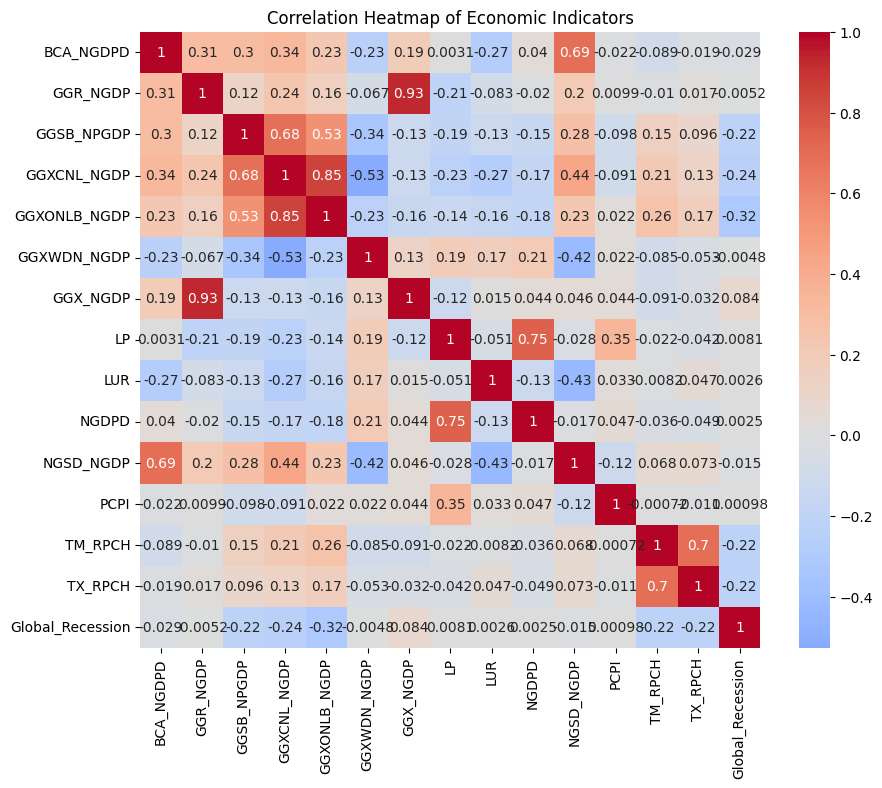

In [10]:
# --- 3. Exploratory Plots ---
# Heatmap
plt.figure(figsize=(10,8))
corr = df_filtered.drop(columns=["Country"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()

In [11]:
# Model imports (data/numeric/visual imports are at the top of the notebook)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       252
           1       0.00      0.00      0.00        67

    accuracy                           0.79       319
   macro avg       0.39      0.50      0.44       319
weighted avg       0.62      0.79      0.70       319

Training Accuracy: 0.791
Test Accuracy: 0.790
Logistic Regression Feature Importance:
         Feature   Coefficient  Abs_Importance
11          PCPI -5.336781e-14    5.336781e-14
9          NGDPD -1.096493e-21    1.096493e-21
5    GGXWDN_NGDP -5.743947e-23    5.743947e-23
6       GGX_NGDP -4.993520e-23    4.993520e-23
1       GGR_NGDP -4.847533e-23    4.847533e-23
7             LP -4.189005e-23    4.189005e-23
10     NGSD_NGDP -2.990078e-23    2.990078e-23
8            LUR -1.106019e-23    1.106019e-23
12       TM_RPCH -9.935009e-24    9.935009e-24
13       TX_RPCH -9.569542e-24    9.569542e-24
2     GGSB_NPGDP  2.346226e-24    2.346226e-24

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

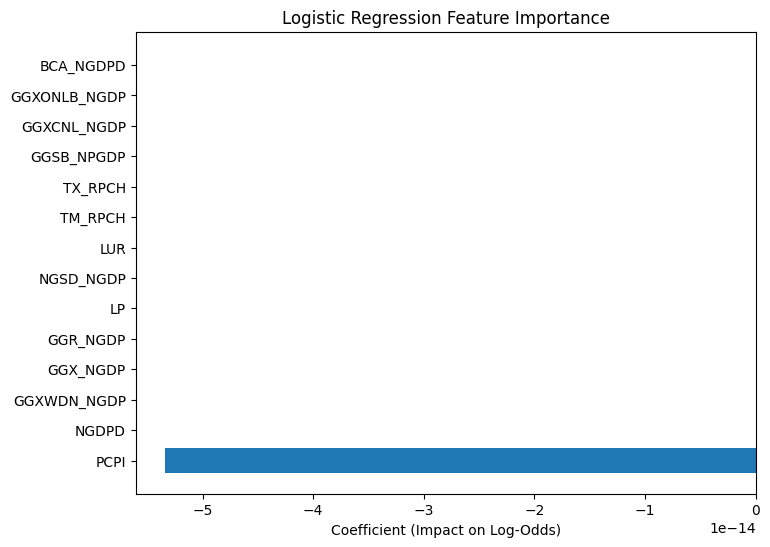

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Logistic Regression coefficients
coefficients = model.coef_[0]
features = X_train.columns

logit_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients,
    "Abs_Importance": np.abs(coefficients)
}).sort_values(by="Abs_Importance", ascending=False)

print("Logistic Regression Feature Importance:")
print(logit_importance)

# Plot feature importance
plt.figure(figsize=(8,6))
plt.barh(logit_importance["Feature"], logit_importance["Coefficient"])
plt.xlabel("Coefficient (Impact on Log-Odds)")
plt.title("Logistic Regression Feature Importance")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       252
           1       0.79      0.40      0.53        67

    accuracy                           0.85       319
   macro avg       0.83      0.69      0.72       319
weighted avg       0.85      0.85      0.83       319

Training Accuracy: 1.000
Test Accuracy: 0.853
Random Forest Feature Importance:
         Feature  Importance
12       TM_RPCH    0.160881
13       TX_RPCH    0.126007
4   GGXONLB_NGDP    0.107468
11          PCPI    0.079726
3    GGXCNL_NGDP    0.063570
2     GGSB_NPGDP    0.061983
7             LP    0.052440
5    GGXWDN_NGDP    0.052340
0      BCA_NGDPD    0.051551
8            LUR    0.050720
6       GGX_NGDP    0.050702
10     NGSD_NGDP    0.050250
1       GGR_NGDP    0.047003
9          NGDPD    0.045360


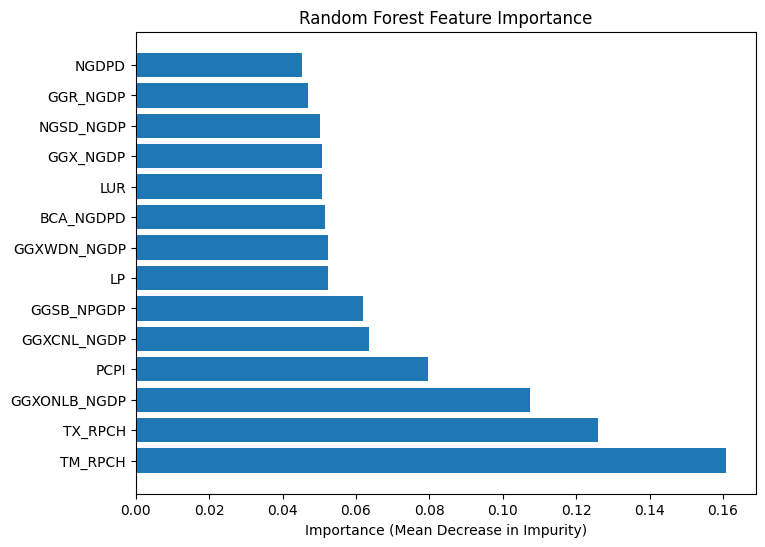

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Random Forest feature importance
rf_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance)

# Plot feature importance
plt.figure(figsize=(8,6))
plt.barh(rf_importance["Feature"], rf_importance["Importance"])
plt.xlabel("Importance (Mean Decrease in Impurity)")
plt.title("Random Forest Feature Importance")
plt.show()


Gradient Boosting:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       252
           1       0.88      0.43      0.58        67

    accuracy                           0.87       319
   macro avg       0.87      0.71      0.75       319
weighted avg       0.87      0.87      0.85       319

Training Accuracy: 0.932
Test Accuracy: 0.868
Gradient Boosting Feature Importance:
         Feature  Importance
12       TM_RPCH    0.338318
11          PCPI    0.140860
4   GGXONLB_NGDP    0.136675
13       TX_RPCH    0.114993
5    GGXWDN_NGDP    0.041706
6       GGX_NGDP    0.039547
3    GGXCNL_NGDP    0.037271
2     GGSB_NPGDP    0.030832
8            LUR    0.025090
1       GGR_NGDP    0.024924
9          NGDPD    0.021320
10     NGSD_NGDP    0.020138
7             LP    0.015541
0      BCA_NGDPD    0.012785


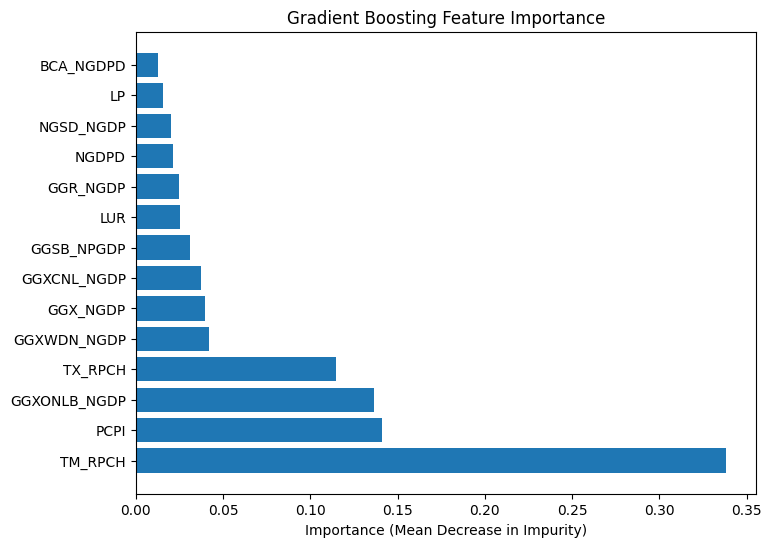

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predictions
y_pred = gb.predict(X_test)

# Classification report
print("Gradient Boosting:\n", classification_report(y_test, y_pred))

# Accuracy
train_acc = accuracy_score(y_train, gb.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Feature importance
gb_importance = pd.DataFrame({
    "Feature": features,
    "Importance": gb.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Gradient Boosting Feature Importance:")
print(gb_importance)

# Plot feature importance
plt.figure(figsize=(8,6))
plt.barh(gb_importance["Feature"], gb_importance["Importance"])
plt.xlabel("Importance (Mean Decrease in Impurity)")
plt.title("Gradient Boosting Feature Importance")
plt.show()


In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train Linear SVM
linear_svm = LinearSVC(random_state=42, max_iter=5000)
linear_svm.fit(X_train, y_train)

# Feature importance (coefficients)
svm_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": linear_svm.coef_[0],
    "Abs_Importance": np.abs(linear_svm.coef_[0])
}).sort_values(by="Abs_Importance", ascending=False)

print("Linear SVM Feature Importance:")
print(svm_importance)

# Accuracy on train and test sets
train_acc = accuracy_score(y_train, linear_svm.predict(X_train))
test_acc = accuracy_score(y_test, linear_svm.predict(X_test))

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Linear SVM Feature Importance:
         Feature   Coefficient  Abs_Importance
11          PCPI -2.126188e-14    2.126188e-14
9          NGDPD -4.072810e-23    4.072810e-23
5    GGXWDN_NGDP -2.103188e-24    2.103188e-24
6       GGX_NGDP -1.829266e-24    1.829266e-24
1       GGR_NGDP -1.772654e-24    1.772654e-24
7             LP -1.645990e-24    1.645990e-24
10     NGSD_NGDP -1.088544e-24    1.088544e-24
8            LUR -4.052264e-25    4.052264e-25
12       TM_RPCH -3.602839e-25    3.602839e-25
13       TX_RPCH -3.479134e-25    3.479134e-25
2     GGSB_NPGDP  8.848788e-26    8.848788e-26
3    GGXCNL_NGDP  5.661063e-26    5.661063e-26
4   GGXONLB_NGDP -5.103753e-26    5.103753e-26
0      BCA_NGDPD  4.100848e-26    4.100848e-26
Training Accuracy: 0.791
Test Accuracy: 0.790


In [16]:
from sklearn.metrics import classification_report, accuracy_score

# --- KNN ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred))

train_acc = accuracy_score(y_train, knn.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"KNN Training Accuracy: {train_acc:.3f}")
print(f"KNN Test Accuracy: {test_acc:.3f}\n")

# --- Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred))

train_acc = accuracy_score(y_train, nb.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Training Accuracy: {train_acc:.3f}")
print(f"Naive Bayes Test Accuracy: {test_acc:.3f}\n")

# --- MLP ---
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP:\n", classification_report(y_test, y_pred))

train_acc = accuracy_score(y_train, mlp.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"MLP Training Accuracy: {train_acc:.3f}")
print(f"MLP Test Accuracy: {test_acc:.3f}")


KNN:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88       252
           1       0.44      0.12      0.19        67

    accuracy                           0.78       319
   macro avg       0.62      0.54      0.53       319
weighted avg       0.73      0.78      0.73       319

KNN Training Accuracy: 0.823
KNN Test Accuracy: 0.784

Naive Bayes:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       252
           1       0.00      0.00      0.00        67

    accuracy                           0.79       319
   macro avg       0.39      0.50      0.44       319
weighted avg       0.62      0.79      0.70       319

Naive Bayes Training Accuracy: 0.791
Naive Bayes Test Accuracy: 0.790

MLP:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       252
           1       0.55      0.39      0.46        67

    accuracy                  

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

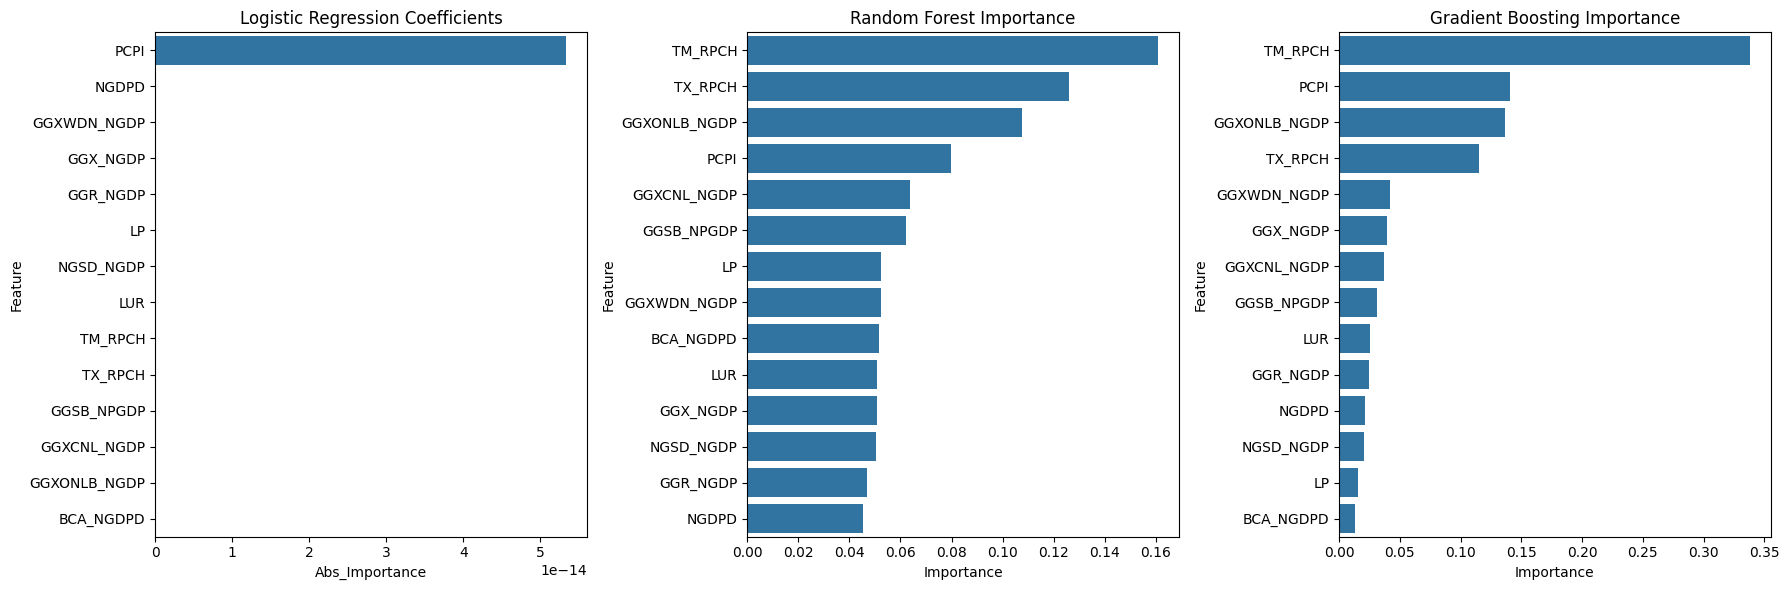

In [17]:
# Compare feature importance for models that support it
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.barplot(x="Abs_Importance", y="Feature", data=logit_importance, ax=axes[0])
axes[0].set_title("Logistic Regression Coefficients")

sns.barplot(x="Importance", y="Feature", data=rf_importance, ax=axes[1])
axes[1].set_title("Random Forest Importance")

sns.barplot(x="Importance", y="Feature", data=gb_importance, ax=axes[2])
axes[2].set_title("Gradient Boosting Importance")

plt.tight_layout()
plt.show()


In [18]:
# --- Print accuracies for all models ---
from sklearn.metrics import accuracy_score

# Logistic Regression
logit_train_acc = accuracy_score(y_train, model.predict(X_train))
logit_test_acc = accuracy_score(y_test, model.predict(X_test))

# Random Forest
rf_train_acc = accuracy_score(y_train, rf.predict(X_train))
rf_test_acc = accuracy_score(y_test, rf.predict(X_test))

# Gradient Boosting
gb_train_acc = accuracy_score(y_train, gb.predict(X_train))
gb_test_acc = accuracy_score(y_test, gb.predict(X_test))

# Linear SVM
svm_train_acc = accuracy_score(y_train, linear_svm.predict(X_train))
svm_test_acc = accuracy_score(y_test, linear_svm.predict(X_test))

# KNN
knn_train_acc = accuracy_score(y_train, knn.predict(X_train))
knn_test_acc = accuracy_score(y_test, knn.predict(X_test))

# Naive Bayes
nb_train_acc = accuracy_score(y_train, nb.predict(X_train))
nb_test_acc = accuracy_score(y_test, nb.predict(X_test))

# MLP
mlp_train_acc = accuracy_score(y_train, mlp.predict(X_train))
mlp_test_acc = accuracy_score(y_test, mlp.predict(X_test))

print("Model Accuracies:")
print(f"Logistic Regression - Train: {logit_train_acc:.3f}, Test: {logit_test_acc:.3f}")
print(f"Random Forest       - Train: {rf_train_acc:.3f}, Test: {rf_test_acc:.3f}")
print(f"Gradient Boosting   - Train: {gb_train_acc:.3f}, Test: {gb_test_acc:.3f}")
print(f"Linear SVM          - Train: {svm_train_acc:.3f}, Test: {svm_test_acc:.3f}")
print(f"KNN                 - Train: {knn_train_acc:.3f}, Test: {knn_test_acc:.3f}")
print(f"Naive Bayes         - Train: {nb_train_acc:.3f}, Test: {nb_test_acc:.3f}")
print(f"MLP                 - Train: {mlp_train_acc:.3f}, Test: {mlp_test_acc:.3f}")


Model Accuracies:
Logistic Regression - Train: 0.791, Test: 0.790
Random Forest       - Train: 1.000, Test: 0.853
Gradient Boosting   - Train: 0.932, Test: 0.868
Linear SVM          - Train: 0.791, Test: 0.790
KNN                 - Train: 0.823, Test: 0.784
Naive Bayes         - Train: 0.791, Test: 0.790
MLP                 - Train: 0.818, Test: 0.806


## Modeling with Reduced Feature Set

Retrain all models using only 4 features: TM_RPCH, PCPI, GGXONLB_NGDP, TX_RPCH

In [ ]:
# Select only the 4 features
selected_features = ['TM_RPCH', 'PCPI', 'GGXONLB_NGDP', 'TX_RPCH']
X_reduced = df_filtered[selected_features]
y_reduced = df_filtered["Global_Recession"]

# Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

print(f"Reduced feature set: {selected_features}")
print(f"Training set: {X_train_r.shape}, Test set: {X_test_r.shape}")

In [ ]:
# Logistic Regression with reduced features
model_r = LogisticRegression(max_iter=1000)
model_r.fit(X_train_r, y_train_r)
y_pred_r = model_r.predict(X_test_r)

print("REDUCED FEATURES - Logistic Regression")
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, model_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}")

# Feature importance
logit_importance_r = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": model_r.coef_[0],
    "Abs_Importance": np.abs(model_r.coef_[0])
}).sort_values(by="Abs_Importance", ascending=False)
print("\nFeature Importance:")
print(logit_importance_r)

In [ ]:
# Random Forest with reduced features
rf_r = RandomForestClassifier(n_estimators=100, random_state=42)
rf_r.fit(X_train_r, y_train_r)
y_pred_r = rf_r.predict(X_test_r)

print("REDUCED FEATURES - Random Forest")
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, rf_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}")

# Feature importance
rf_importance_r = pd.DataFrame({
    "Feature": selected_features,
    "Importance": rf_r.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance:")
print(rf_importance_r)

In [ ]:
# Gradient Boosting with reduced features
gb_r = GradientBoostingClassifier(random_state=42)
gb_r.fit(X_train_r, y_train_r)
y_pred_r = gb_r.predict(X_test_r)

print("REDUCED FEATURES - Gradient Boosting")
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, gb_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}")

# Feature importance
gb_importance_r = pd.DataFrame({
    "Feature": selected_features,
    "Importance": gb_r.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance:")
print(gb_importance_r)

In [ ]:
# Linear SVM with reduced features
linear_svm_r = LinearSVC(random_state=42, max_iter=5000)
linear_svm_r.fit(X_train_r, y_train_r)

print("REDUCED FEATURES - Linear SVM")
print(f"Training Accuracy: {accuracy_score(y_train_r, linear_svm_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, linear_svm_r.predict(X_test_r)):.3f}")

# Feature importance
svm_importance_r = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": linear_svm_r.coef_[0],
    "Abs_Importance": np.abs(linear_svm_r.coef_[0])
}).sort_values(by="Abs_Importance", ascending=False)
print("\nFeature Importance:")
print(svm_importance_r)

In [ ]:
# KNN, Naive Bayes, MLP with reduced features
print("REDUCED FEATURES - KNN")
knn_r = KNeighborsClassifier(n_neighbors=5)
knn_r.fit(X_train_r, y_train_r)
y_pred_r = knn_r.predict(X_test_r)
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, knn_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}\n")

print("REDUCED FEATURES - Naive Bayes")
nb_r = GaussianNB()
nb_r.fit(X_train_r, y_train_r)
y_pred_r = nb_r.predict(X_test_r)
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, nb_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}\n")

print("REDUCED FEATURES - MLP")
mlp_r = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp_r.fit(X_train_r, y_train_r)
y_pred_r = mlp_r.predict(X_test_r)
print("Classification Report:\n", classification_report(y_test_r, y_pred_r))
print(f"Training Accuracy: {accuracy_score(y_train_r, mlp_r.predict(X_train_r)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_r, y_pred_r):.3f}")

In [ ]:
# Compare all models with reduced features
print("="*80)
print("REDUCED FEATURES MODEL COMPARISON")
print("="*80)
print("\nModel Accuracies (4 Features: TM_RPCH, PCPI, GGXONLB_NGDP, TX_RPCH):")
print(f"Logistic Regression - Train: {accuracy_score(y_train_r, model_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, model_r.predict(X_test_r)):.3f}")
print(f"Random Forest       - Train: {accuracy_score(y_train_r, rf_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, rf_r.predict(X_test_r)):.3f}")
print(f"Gradient Boosting   - Train: {accuracy_score(y_train_r, gb_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, gb_r.predict(X_test_r)):.3f}")
print(f"Linear SVM          - Train: {accuracy_score(y_train_r, linear_svm_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, linear_svm_r.predict(X_test_r)):.3f}")
print(f"KNN                 - Train: {accuracy_score(y_train_r, knn_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, knn_r.predict(X_test_r)):.3f}")
print(f"Naive Bayes         - Train: {accuracy_score(y_train_r, nb_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, nb_r.predict(X_test_r)):.3f}")
print(f"MLP                 - Train: {accuracy_score(y_train_r, mlp_r.predict(X_train_r)):.3f}, Test: {accuracy_score(y_test_r, mlp_r.predict(X_test_r)):.3f}")

In [ ]:
# Visualize feature importance comparison for reduced features
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.barplot(x="Abs_Importance", y="Feature", data=logit_importance_r, ax=axes[0])
axes[0].set_title("Logistic Regression (4 Features)")

sns.barplot(x="Importance", y="Feature", data=rf_importance_r, ax=axes[1])
axes[1].set_title("Random Forest (4 Features)")

sns.barplot(x="Importance", y="Feature", data=gb_importance_r, ax=axes[2])
axes[2].set_title("Gradient Boosting (4 Features)")

plt.suptitle("Feature Importance with Reduced Feature Set", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Map countries to continents and create continent-specific DataFrames
# Attempt to use pycountry + pycountry_convert if available, otherwise use fallback mapping
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America',
                'AN': 'Antarctica'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
        'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
        'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
        'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
        'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
        'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
        'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
        'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
        'Australia': 'Oceania', 'New_Zealand': 'Oceania',
        'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
        'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',
        # Additional countries from unmapped list
        'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
        'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
        'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
        'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
        'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
        'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
        'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
        'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
        'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
        'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
        'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
        'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
        'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America'
    }
    
    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# Add Continent column to df_filtered
df_filtered_copy = df_pivot
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# Create continent-specific DataFrames as globals
continent_names = sorted(df_filtered_copy['Continent'].dropna().unique())
created = []

for cont in continent_names:
    safe = str(cont).replace(' ', '_')
    df_name = f'df_{safe}'
    subset = df_filtered_copy[df_filtered_copy['Continent'] == cont].copy()
    # Remove the Continent column from the subset
    subset = subset.drop(columns=['Continent'])
    globals()[df_name] = subset
    created.append((cont, df_name, len(subset)))

# Print summary
print('Created continent-specific DataFrames:')
for cont, var_name, rows in created:
    print(f' - {cont}: {var_name} (rows: {rows})')

Created continent-specific DataFrames:
 - Africa: df_Africa (rows: 87)
 - Asia: df_Asia (rows: 184)
 - Europe: df_Europe (rows: 1173)
 - North_America: df_North_America (rows: 237)
 - Oceania: df_Oceania (rows: 77)
 - South_America: df_South_America (rows: 169)


C:\Users\ningw\AppData\Local\Temp\ipykernel_36648\3789119172.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)


In [21]:
df_Oceania

,Country,BCA_NGDPD,GGR_NGDP,GGSB_NPGDP,GGXCNL_NGDP,GGXONLB_NGDP,GGXWDN_NGDP,GGX_NGDP,LP,LUR,NGDPD,NGSD_NGDP,PCPI,TM_RPCH,TX_RPCH,Global_Recession
Year,,,,,,,,,,,,,,,,
1990,Australia,-4.859,30.243,-0.286,-0.232,1.871,9.564,30.475,17.170,6.942,324.128,22.988,57.450,-3.865,7.537,1
1991,Australia,-3.287,30.271,-2.047,-2.788,-0.978,12.595,33.059,17.379,9.608,324.436,18.349,59.350,-2.597,12.923,1
1992,Australia,-3.283,29.312,-3.809,-4.745,-3.115,18.217,34.057,17.557,10.742,318.005,19.263,59.925,6.853,6.422,1
1993,Australia,-3.036,29.412,-4.053,-4.727,-2.898,22.052,34.138,17.719,10.883,309.303,21.103,60.975,5.161,8.375,1
1994,Australia,-4.491,29.949,-3.171,-3.793,-1.783,23.232,33.742,17.893,9.717,353.372,21.604,62.150,14.287,7.940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,New_Zealand,-4.704,37.951,-4.256,-3.966,-2.283,27.596,41.917,5.470,5.283,259.160,18.157,190.339,3.752,4.253,0
2027,New_Zealand,-4.362,38.178,-3.084,-2.537,-0.698,28.742,40.715,5.549,4.717,270.294,18.423,194.175,3.430,4.370,0
2028,New_Zealand,-4.016,38.408,-1.957,-1.445,0.521,28.707,39.853,5.630,4.453,281.646,18.734,198.088,3.488,4.419,0


## 8) Export

Write the cleaned panel to CSV for downstream analysis or modeling.

### Results and Export

After running the cleaning and modeling sections, inspect `df_pivot`/`df_filtered` outputs (head, tail, non-null counts) before exporting. The following export cell writes `weo_data_clean.csv`.

In [20]:
# Write dataframe to CSV
df_pivot.to_csv("weo_data_clean.csv", index=True)
